# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

- portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
- profile.json - demographic data for each customer
- transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

#### portfolio.json

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

#### profile.json

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

#### transcript.json

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

## Overview of the project and analysis plan

#### Understanding of the data
- After reading the description and looking into the data, I found this dataset includes two main questions: 

(1) some customers didn't receive or complete the offer, but still keep purchasing. 

(2) Some customers received the offer but might not complet the offer during the required duration, while others completed the offer.Futhermore, for different offers, they have different features (e.g. offer type, reward amount, channel, duration etc.)

#### Research questions

- Based on the above understanding, I am planning to perfom two main analysis on the current dataset. 

(1) For those customers who didn't use offer, I am interested to explore which demographic factors would predict their purchases. I plan to use LinearRegression ML approach to perform this analysis.

(2) For those customers who completed the offer during the required duration, I aimed to explore which factors would predict the offer complete outcomes. I plan to use RandomForest ML approach to perform this analysis.

In [129]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### STEP 1.  Data preparation and explorotory visualization

- overview the datasets;
- check missing values;
- merge related dataframes

#### portfolio dataframe cleaning

In [5]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
# create dummy values for offer channels for the purpose of the final machine learning analysis
channel_list = ['web','email','mobile','social']
for channel in channel_list:
    portfolio[channel] = portfolio['channels'].apply(lambda x: channel in x)*1
    portfolio_clean=portfolio.drop('channels',axis=1)
# create dummy values for offer_type, drop the original column
portfolio_clean = pd.concat([portfolio_clean.drop('offer_type',axis=1),pd.get_dummies(portfolio_clean['offer_type'])],axis=1)
portfolio_clean=portfolio_clean.rename({'id':'offer_id'},axis=1)
portfolio_clean

,reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


#### Profile dataframe cleaning

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
# because the customer information is important for the further analysis, so I drop the profile null values
profile_clean = profile.dropna()
profile_clean.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [11]:
profile_clean.shape

(14825, 5)

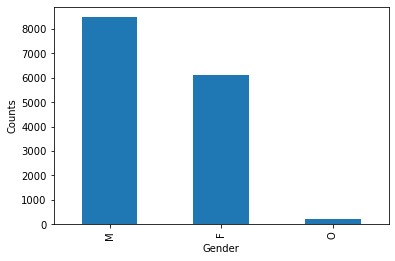

In [12]:
# plot the age distribution of customers

profile_clean['gender'].value_counts().plot(kind='bar');
plt.xlabel('Gender');
plt.ylabel('Counts');

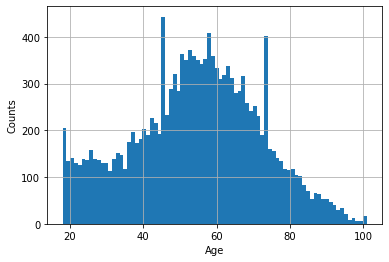

In [13]:
# Plot the age distribution of the customers
profile_clean['age'].hist(bins=80);
plt.xlabel('Age');
plt.ylabel('Counts');

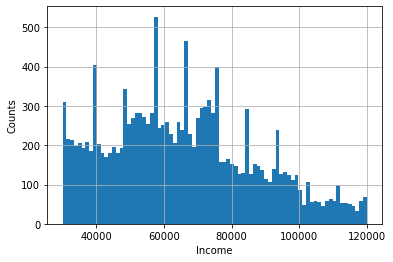

In [14]:
# Plot the income distribution of the customers
profile_clean['income'].hist(bins=80);
plt.xlabel('Income');
plt.ylabel('Counts');

#### Based on the above distribution, I added the Age group and income group information for the profile Table. The details of group are as below:

##### Age group

- $\lt$ 20 years
- 20-40 years
- 40-60 years
- 60-80 years
- $\ge$ 80 years

##### Income group

- $\lt$ 40,000

- 40,000-60,000

- 60,000-80,000

- 80,000-100,000

- $\ge$ 100,000


In [15]:
profile_clean.head()

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [16]:
# create age group
def Get_Age_Group(x):
    if x['age']<20:
        return '<20 years'
    if x['age']>=20 and x['age']<40:
        return '20-40 years'
    if x['age']>=40 and x['age']<60: 
        return '40-60 years'
    if x['age']>=60 and x['age']<80: 
        return '60-80 years'
    if x['age']>=80: 
        return '>=80years'
profile_clean['age_group']=profile_clean.apply(Get_Age_Group,axis=1)
profile_clean.head()

<ipython-input-16-3c6417ed3574>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_clean['age_group']=profile_clean.apply(Get_Age_Group,axis=1)


,gender,age,id,became_member_on,income,age_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,40-60 years
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,60-80 years
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,60-80 years
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,60-80 years
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,40-60 years


In [17]:
# create Income group
def Get_Income_Group(x):
    if x['income']<40000:
        return '<$40,000'
    if x['income']>=40000 and x['income']<60000:
        return '$40,000-60,000'
    if x['income']>=60000 and x['income']<80000: 
        return '$60,000-80,000'
    if x['income']>=80000 and x['income']<100000: 
        return '$80,000-100,000'
    if x['income']>=100000: 
        return '>=$100,000'
profile_clean['income_group']=profile_clean.apply(Get_Income_Group,axis=1)
profile_clean.head()

<ipython-input-17-b440915c05a9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_clean['income_group']=profile_clean.apply(Get_Income_Group,axis=1)


,gender,age,id,became_member_on,income,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,40-60 years,">=$100,000"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,60-80 years,">=$100,000"
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0,60-80 years,"$60,000-80,000"
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,60-80 years,"$40,000-60,000"
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,40-60 years,"$40,000-60,000"


- First, I would like to see the number of new member change along the time by age group

In [18]:
# convert the became_member_on to date format
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'],format = '%Y%m%d')
# change id to customer_id
profile_clean = profile_clean.rename({'id':'customer_id'},axis=1)
profile_clean.head()

<ipython-input-18-8259d86e9e27>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'],format = '%Y%m%d')


,gender,age,customer_id,became_member_on,income,age_group,income_group
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000"
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,60-80 years,">=$100,000"
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,60-80 years,"$60,000-80,000"
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,60-80 years,"$40,000-60,000"
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,40-60 years,"$40,000-60,000"


In [19]:
profile_clean['member_Year']=profile_clean['became_member_on'].dt.year
member_time =pd.DataFrame(profile_clean.groupby(['member_Year','age_group'])['customer_id'].count())
member_time=member_time.rename({'customer_id':'member_counts'},axis=1)
member_time

member_counts
member_Year age_group                 
2013        20-40 years             62
            40-60 years            100
            60-80 years             93
            <20 years                5
            >=80years               14
2014        20-40 years            164
            40-60 years            266
            60-80 years            186
            <20 years               11
            >=80years               35
2015        20-40 years            289
            40-60 years            655
            60-80 years            504
            <20 years               25
            >=80years              124
2016        20-40 years            446
            40-60 years           1225
            60-80 years           1050
            <20 years               33
            >=80years              270
2017        20-40 years           1124
            40-60 years           2192
            60-80 years           1795
            <20 years               76
            >=80years              412
2018        20-40 years            810
            40-60 years           1412
            60-80 years           1145
            <20 years               55
            >=80years              247

In [20]:
member_year = member_time.reset_index()
member_year.head()

,member_Year,age_group,member_counts
0,2013,20-40 years,62
1,2013,40-60 years,100
2,2013,60-80 years,93
3,2013,<20 years,5
4,2013,>=80years,14


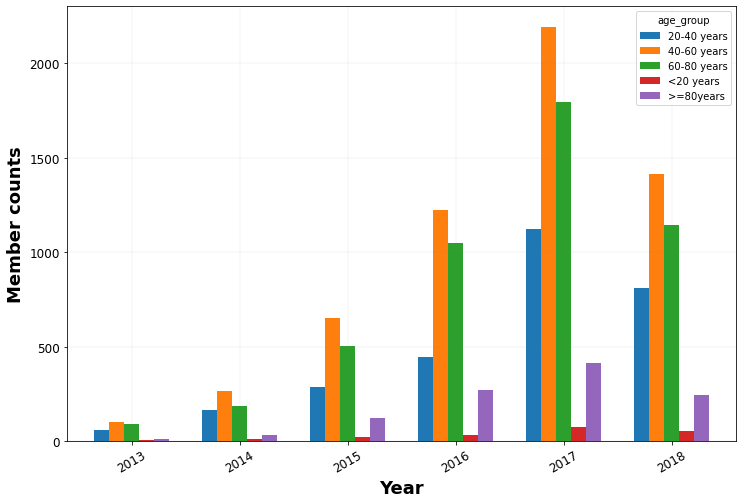

In [21]:
ax=member_year.pivot('member_Year','age_group','member_counts').plot(kind='bar',width=0.7,figsize=(12,8));
ax.grid(b=True,color='grey',alpha=0.3,linewidth=0.3)
plt.xlabel('Year',fontsize=18,fontweight='bold')
plt.ylabel('Member counts',fontsize=18,fontweight='bold')
plt.xticks(fontsize = 12,rotation=30)
plt.yticks(fontsize=12)
plt.show();

- So, we can see that from 2013 to 2018, the number of new members is increased across all age groups (Given the data of 2018 was not the full year, so we assumed it is still increased in 2018). Specifically, the member number in the 40-60 years age group is the highest.

#### transcript dataframe cleaning

In [145]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [23]:
transcript.shape

(306534, 4)

In [24]:
pd.DataFrame(transcript["value"].tolist())

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [536]:
# split value column to different columns
offer_values = pd.DataFrame(transcript["value"].tolist())
transcript_clean = pd.concat([transcript.drop('value',axis=1),offer_values],axis=1)
transcript_clean['offer_id']=transcript_clean['offer_id'].fillna(transcript_clean['offer id'])
transcript_clean=transcript_clean.drop(columns=['offer id'])
# rename person to customer_id
transcript_clean = transcript_clean.rename({'person':'customer_id'},axis=1)
transcript_clean = transcript_clean.rename({'amount':'transaction_amount'},axis=1)
transcript_clean = transcript_clean.rename({'reward':'offer_reward'},axis=1)
# create dummy values for event column
transcript_clean = pd.concat([transcript_clean.drop('event',axis=1),pd.get_dummies(transcript_clean['event'])],axis=1)
#change reward to integer
transcript_clean['transaction_amount'] = transcript_clean['transaction_amount'].replace(np.nan, 0)
transcript_clean['offer_reward'] = transcript_clean['offer_reward'].replace(np.nan, 0)
transcript_clean['transaction_amount'] = transcript_clean['transaction_amount'].replace(np.nan, 0)

transcript_clean.head()

,customer_id,time,transaction_amount,offer_id,offer_reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0


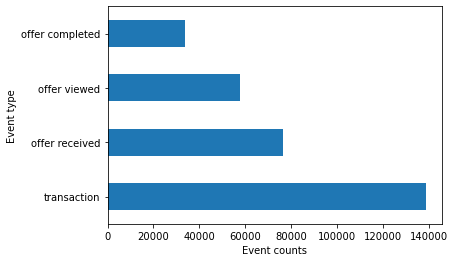

In [537]:
# plot the distribution of the four event types

transcript['event'].value_counts().plot(kind='barh');
plt.xlabel('Event counts');
plt.ylabel('Event type');

In [538]:
transcript_clean.head()

,customer_id,time,transaction_amount,offer_id,offer_reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,0.0,2906b810c7d4411798c6938adc9daaa5,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0.0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,0.0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0


In [539]:
profile_clean.head()

,gender,age,customer_id,became_member_on,income,age_group,income_group,member_Year
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000",2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,60-80 years,">=$100,000",2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,60-80 years,"$60,000-80,000",2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,60-80 years,"$40,000-60,000",2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,40-60 years,"$40,000-60,000",2017


#### Merge transcript to profile dataset

In [540]:
# Merge the transcript and profile datasets
customer_offer = pd.merge(profile_clean,transcript_clean,how='outer',on=['customer_id'])
customer_offer

,gender,age,customer_id,became_member_on,income,age_group,income_group,member_Year,time,transaction_amount,offer_id,offer_reward,offer completed,offer received,offer viewed,transaction
0,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000",2017.0,18,21.51,NaN,0.0,0,0,0,1
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000",2017.0,144,32.28,NaN,0.0,0,0,0,1
2,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000",2017.0,408,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0,1,0,0
3,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000",2017.0,504,0.00,3f207df678b143eea3cee63160fa8bed,0.0,0,1,0,0
4,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,40-60 years,">=$100,000",2017.0,528,23.22,NaN,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,NaN,NaN,ebae5093b436466c9fbd097cb7434023,NaT,NaN,NaN,NaN,NaN,660,12.64,NaN,0.0,0,0,0,1
306530,NaN,NaN,ebae5093b436466c9fbd097cb7434023,NaT,NaN,NaN,NaN,NaN,660,0.00,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0,0,0
306531,NaN,NaN,912b9f623b9e4b4eb99b6dc919f09a93,NaT,NaN,NaN,NaN,NaN,576,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,1,0,0
306532,NaN,NaN,912b9f623b9e4b4eb99b6dc919f09a93,NaT,NaN,NaN,NaN,NaN,594,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0,0,1,0


#### Merge customer_offer to portfolio

In [530]:
offer_df = pd.merge(portfolio_clean,customer_offer,how='outer',on=['offer_id'])
offer_df = offer_df.rename({'reward':'complete_reward'},axis=1)
offer_df

,complete_reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,...,age_group,income_group,member_Year,time,transaction_amount,offer_reward,offer completed,offer received,offer viewed,transaction
0,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,60-80 years,">=$100,000",2017.0,408,0.00,0.0,0,1,0,0
1,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,60-80 years,">=$100,000",2017.0,408,0.00,0.0,0,0,1,0
2,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,60-80 years,">=$100,000",2017.0,510,0.00,10.0,1,0,0,0
3,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,60-80 years,"$40,000-60,000",2017.0,408,0.00,0.0,0,1,0,0
4,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,60-80 years,"$40,000-60,000",2017.0,426,0.00,10.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,672,0.05,0.0,0,0,0,1
306530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,678,9.46,0.0,0,0,0,1
306531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,516,2.57,0.0,0,0,0,1
306532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,660,12.64,0.0,0,0,0,1


## STEP 2 Machine learning analysis

- Clean the dataset further for the next analysis

In [541]:
offer_df.columns

Index(['complete_reward', 'difficulty', 'duration', 'offer_id', 'web', 'email',
       'mobile', 'social', 'bogo', 'discount', 'informational', 'gender',
       'age', 'customer_id', 'became_member_on', 'income', 'age_group',
       'income_group', 'member_Year', 'time', 'transaction_amount',
       'offer_reward', 'offer completed', 'offer received', 'offer viewed',
       'transaction', 'day'],
      dtype='object')

In [545]:
# Change time into days
offer_df['time']=offer_df['time'].fillna(0.0)
offer_df['day']=offer_df['time'].apply(lambda x: x/24.0)
#drop unuseful columns
offer_clean = offer_df.drop(columns=['became_member_on','member_Year','time','age','income'])
offer_clean

,complete_reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,...,customer_id,age_group,income_group,transaction_amount,offer_reward,offer completed,offer received,offer viewed,transaction,day
0,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",0.00,0.0,0,1,0,0,17.00
1,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",0.00,0.0,0,0,1,0,17.00
2,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",0.00,10.0,1,0,0,0,21.25
3,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,aa4862eba776480b8bb9c68455b8c2e1,60-80 years,"$40,000-60,000",0.00,0.0,0,1,0,0,17.00
4,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,aa4862eba776480b8bb9c68455b8c2e1,60-80 years,"$40,000-60,000",0.00,10.0,1,0,0,0,17.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,bad805c0568d49ae9bf2f046b6ea2be0,NaN,NaN,0.05,0.0,0,0,0,1,28.00
306530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,bad805c0568d49ae9bf2f046b6ea2be0,NaN,NaN,9.46,0.0,0,0,0,1,28.25
306531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ebae5093b436466c9fbd097cb7434023,NaN,NaN,2.57,0.0,0,0,0,1,21.50
306532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ebae5093b436466c9fbd097cb7434023,NaN,NaN,12.64,0.0,0,0,0,1,27.50


In [546]:
# check the null values again
offer_clean.isnull().sum()

complete_reward       138953
difficulty            138953
duration              138953
offer_id              138953
web                   138953
email                 138953
mobile                138953
social                138953
bogo                  138953
discount              138953
informational         138953
gender                 33772
customer_id                0
age_group              33772
income_group           33772
transaction_amount         0
offer_reward               0
offer completed            0
offer received             0
offer viewed               0
transaction                0
day                        0
dtype: int64

- Now, I neede separate the dataframe into two dataframes. One is the offer_data, the other is dataframe without offer

In [552]:
# dataframe without offer
transaction_df = offer_clean[offer_clean['transaction']==1]
transaction_df.head()

,complete_reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,...,customer_id,age_group,income_group,transaction_amount,offer_reward,offer completed,offer received,offer viewed,transaction,day
167581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0610b486422d4921ae7d2bf64640c50b,40-60 years,">=$100,000",21.51,0.0,0,0,0,1,0.75
167582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0610b486422d4921ae7d2bf64640c50b,40-60 years,">=$100,000",32.28,0.0,0,0,0,1,6.00
167583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0610b486422d4921ae7d2bf64640c50b,40-60 years,">=$100,000",23.22,0.0,0,0,0,1,22.00
167584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",19.89,0.0,0,0,0,1,5.50
167585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",17.78,0.0,0,0,0,1,6.00


In [553]:
# In this dataset, I just need the customer information and transaction amount information. So I drop all the unuseful columns
transaction_clean=transaction_df[['customer_id','age_group','gender','income_group','transaction_amount']]
transaction_clean.head()

,customer_id,age_group,gender,income_group,transaction_amount
167581,0610b486422d4921ae7d2bf64640c50b,40-60 years,F,">=$100,000",21.51
167582,0610b486422d4921ae7d2bf64640c50b,40-60 years,F,">=$100,000",32.28
167583,0610b486422d4921ae7d2bf64640c50b,40-60 years,F,">=$100,000",23.22
167584,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,F,">=$100,000",19.89
167585,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,F,">=$100,000",17.78


### Question 1: Which demographic factors predict the average transaction amount without offers?
- my hypothesis is the income might be the most important predictor.

In [554]:
# We can see there are lots of duplicated customer_id, so I need re-organize the dataframe by customer first
transaction_customer=pd.DataFrame(transaction_clean.groupby(['customer_id','age_group','income_group','gender'])['transaction_amount'].mean())
transaction_customer=transaction_customer.reset_index()
transaction_customer

,customer_id,age_group,income_group,gender,transaction_amount
0,0009655768c64bdeb2e877511632db8f,20-40 years,"$60,000-80,000",M,15.950000
1,0011e0d4e6b944f998e987f904e8c1e5,40-60 years,"$40,000-60,000",O,15.892000
2,0020c2b971eb4e9188eac86d93036a77,40-60 years,"$80,000-100,000",F,24.607500
3,0020ccbbb6d84e358d3414a3ff76cffd,20-40 years,"$60,000-80,000",F,12.837500
4,003d66b6608740288d6cc97a6903f4f0,20-40 years,"$60,000-80,000",F,2.685556
...,...,...,...,...,...
14487,fff3ba4757bd42088c044ca26d73817a,60-80 years,"$80,000-100,000",F,52.816364
14488,fff7576017104bcc8677a8d63322b5e1,60-80 years,"$60,000-80,000",M,4.990000
14489,fff8957ea8b240a6b5e634b6ee8eafcf,60-80 years,"$40,000-60,000",M,2.430000
14490,fffad4f4828548d1b5583907f2e9906b,20-40 years,"<$40,000",M,7.402500


In [555]:
def clean_data(df):
    
    '''INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Create X as all the columns that are not the trasanction_amount column
    2. Create y as the trasanction_amount column
    3. Drop the customer_id
    4. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # create X matrix
    X = df.drop(['customer_id','transaction_amount'],axis=1)
    # Create y response
    y = df['transaction_amount']
    # Create dummy columns for all categorical variables
    cat_cols = X.select_dtypes(include=['object']).copy().columns
    for col in cat_cols:
        X = pd.concat([X.drop(col,axis=1),pd.get_dummies(X[col],dummy_na=False)],axis=1)
    return X,y
X_transaction, y_transaction = clean_data(transaction_customer)

In [556]:
X_transaction

,20-40 years,40-60 years,60-80 years,<20 years,>=80years,"$40,000-60,000","$60,000-80,000","$80,000-100,000","<$40,000",">=$100,000",F,M,O
0,1,0,0,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,1,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,1,0,0
4,1,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14487,0,0,1,0,0,0,0,1,0,0,1,0,0
14488,0,0,1,0,0,0,1,0,0,0,0,1,0
14489,0,0,1,0,0,1,0,0,0,0,0,1,0
14490,1,0,0,0,0,0,0,0,1,0,0,1,0


In [557]:
# Split the X, y datasets
X_transaction_train,X_transaction_test,y_transaction_train,y_transaction_test=train_test_split(X_transaction, y_transaction,test_size=.30,random_state=42)
lm_model=LinearRegression(normalize=True)
lm_model.fit(X_transaction_train,y_transaction_train)
y_transaction_train_preds=lm_model.predict(X_transaction_train)
y_transaction_test_preds=lm_model.predict(X_transaction_test)
train_score=r2_score(y_transaction_train,y_transaction_train_preds)
test_score=r2_score(y_transaction_test,y_transaction_test_preds)
print("The rsquared on the training data was {}.The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.25174049214063055.The rsquared on the test data was 0.23664006282230954.


In [558]:
def coef_weights(coefficients,X_transaction_train):
    coefs_df=pd.DataFrame()
    coefs_df['est_int']=X_transaction_train.columns
    coefs_df['coefs']=lm_model.coef_
    coefs_df['abs_coefs']=np.abs(lm_model.coef_)
    coefs_df=coefs_df.sort_values('abs_coefs',ascending=False)
    return coefs_df
coef_df=coef_weights(lm_model.coef_,X_transaction_train)
coef_df

,est_int,coefs,abs_coefs
10,F,2.974810e+14,2.974810e+14
12,O,2.974810e+14,2.974810e+14
11,M,2.974810e+14,2.974810e+14
9,">=$100,000",1.285851e+14,1.285851e+14
7,"$80,000-100,000",1.285851e+14,1.285851e+14
6,"$60,000-80,000",1.285851e+14,1.285851e+14
5,"$40,000-60,000",1.285851e+14,1.285851e+14
8,"<$40,000",1.285851e+14,1.285851e+14
4,>=80years,5.207008e+13,5.207008e+13
2,60-80 years,5.207008e+13,5.207008e+13


- It is interesting that income is not the most important factor predicting the average transaction amount, but gender is the most important one.
- Given this, I would like to explore which gender group has the highest transaction. Since I am still interested to know the influence of income, I will check the both factors together

In [559]:
gender_transaction = pd.DataFrame(transaction_customer.groupby(['gender','income_group'])['transaction_amount'].mean())
gender_transaction=gender_transaction.reset_index()
gender_transaction

,gender,income_group,transaction_amount
0,F,"$40,000-60,000",11.187151
1,F,"$60,000-80,000",18.025831
2,F,"$80,000-100,000",26.892363
3,F,"<$40,000",6.979935
4,F,">=$100,000",30.669316
5,M,"$40,000-60,000",7.924287
6,M,"$60,000-80,000",13.243475
7,M,"$80,000-100,000",27.113485
8,M,"<$40,000",5.154953
9,M,">=$100,000",30.351771


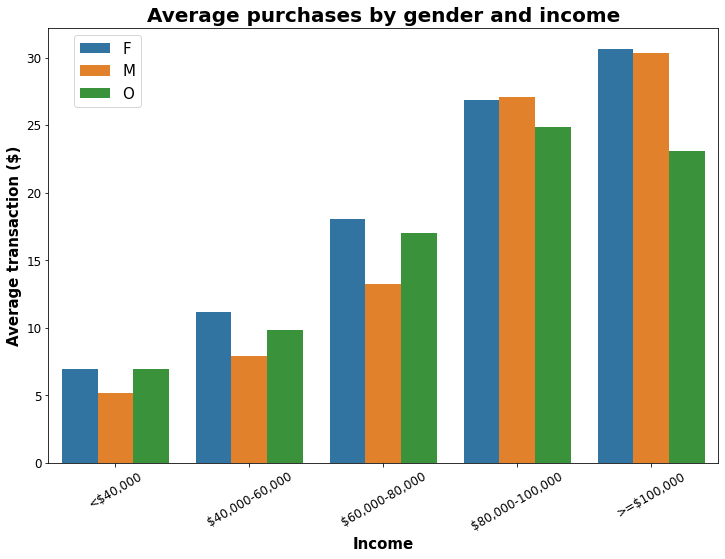

In [560]:
plt.figure(figsize=(12,8))
Income_order=['<$40,000','$40,000-60,000','$60,000-80,000','$80,000-100,000','>=$100,000']
g=sns.barplot(data=gender_transaction,x='income_group',y='transaction_amount',hue='gender',palette="tab10",order=Income_order).set_title('Average purchases by gender and income',fontsize=20,fontweight='bold')
plt.xticks(fontsize = 12,rotation=30)
plt.yticks(fontsize = 12)
plt.xlabel('Income',fontsize=15,fontweight='bold')
plt.ylabel('Average transaction ($)',fontsize=15,fontweight='bold')
plt.legend(bbox_to_anchor=(0.1,0.5,0.05,0.5), loc='upper right',fontsize=15)
figure=g.get_figure()
figure.savefig("Figure 2.jpg")

##### Summary:

- There is a clear trend that the female has the higher transaction than other two gender group;
- Although there is a little bit difference between gender group, overall, the higher income has the higher transaction

### Question 2: Which factors predict whether the customer will complete the offer?
- In this analysis, I categorized the offers into three types: (1) expired offer (i.e. the offer was not opened within the validity period; (2) invalid offer (i.e. customers received or viewed the offer but not completed the offer). (3) valid offer (i.e. customers received, viewed and then complete the offer during the validity period); 


- The three offer types will be used as the response variables, and the other variables will be used as predictors to build the model.


- I'll test three different models (i.e. Logistic regression; RandomForest; DecisionTree) and compare the results

In [561]:
offer_clean

,complete_reward,difficulty,duration,offer_id,web,email,mobile,social,bogo,discount,...,customer_id,age_group,income_group,transaction_amount,offer_reward,offer completed,offer received,offer viewed,transaction,day
0,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",0.00,0.0,0,1,0,0,17.00
1,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",0.00,0.0,0,0,1,0,17.00
2,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,78afa995795e4d85b5d9ceeca43f5fef,60-80 years,">=$100,000",0.00,10.0,1,0,0,0,21.25
3,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,aa4862eba776480b8bb9c68455b8c2e1,60-80 years,"$40,000-60,000",0.00,0.0,0,1,0,0,17.00
4,10.0,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,1.0,1.0,1.0,1.0,0.0,...,aa4862eba776480b8bb9c68455b8c2e1,60-80 years,"$40,000-60,000",0.00,10.0,1,0,0,0,17.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,bad805c0568d49ae9bf2f046b6ea2be0,NaN,NaN,0.05,0.0,0,0,0,1,28.00
306530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,bad805c0568d49ae9bf2f046b6ea2be0,NaN,NaN,9.46,0.0,0,0,0,1,28.25
306531,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ebae5093b436466c9fbd097cb7434023,NaN,NaN,2.57,0.0,0,0,0,1,21.50
306532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,ebae5093b436466c9fbd097cb7434023,NaN,NaN,12.64,0.0,0,0,0,1,27.50


In [562]:
#dataframe with offers
offer_final = offer_clean[offer_clean['offer_id'].notna()]
offer_final.transaction_amount.unique()

array([0.])

In [563]:
offer_final.isnull().sum()

complete_reward           0
difficulty                0
duration                  0
offer_id                  0
web                       0
email                     0
mobile                    0
social                    0
bogo                      0
discount                  0
informational             0
gender                18776
customer_id               0
age_group             18776
income_group          18776
transaction_amount        0
offer_reward              0
offer completed           0
offer received            0
offer viewed              0
transaction               0
day                       0
dtype: int64

In [617]:
# Group the datasets by customer and offer id, and calculate the time of completing the offer
offer_customer=offer_final.groupby(['customer_id','offer_id','gender','age_group','income_group']).agg({'offer completed':max,'offer viewed':max,'offer received':max,'duration':max,'social':max,'web':max,'email':max,'informational':max,'bogo':max,'mobile':max,'discount':max,'complete_reward':sum,'difficulty':max, 'offer_reward':max,'day':['max','min']})
offer_customer=offer_customer.reset_index()
column_names = offer_customer.columns.get_level_values(0).tolist()
column_names[19]='day_max'
column_names[20]='day_min'
offer_customer.columns=column_names
offer_customer['complete_time']=offer_customer['day_max']-offer_customer['day_min']
offer_customer

,customer_id,offer_id,gender,age_group,income_group,offer completed,offer viewed,offer received,duration,social,...,informational,bogo,mobile,discount,complete_reward,difficulty,offer_reward,day_max,day_min,complete_time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,20-40 years,"$60,000-80,000",1,0,1,7.0,0.0,...,0.0,0.0,1.0,1.0,4.0,10.0,2.0,24.00,24.0,0.00
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,M,20-40 years,"$60,000-80,000",0,1,1,4.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,15.50,14.0,1.50
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,M,20-40 years,"$60,000-80,000",0,1,1,3.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.00,7.0,1.00
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,M,20-40 years,"$60,000-80,000",1,1,1,5.0,1.0,...,0.0,1.0,1.0,0.0,15.0,5.0,5.0,19.00,17.0,2.00
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,M,20-40 years,"$60,000-80,000",1,1,1,10.0,1.0,...,0.0,0.0,1.0,1.0,6.0,10.0,2.0,22.50,21.0,1.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,M,20-40 years,"<$40,000",1,1,1,5.0,1.0,...,0.0,1.0,1.0,0.0,30.0,5.0,5.0,21.50,0.0,21.50
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,40-60 years,"$60,000-80,000",1,1,1,10.0,0.0,...,0.0,0.0,0.0,1.0,15.0,20.0,5.0,8.25,7.0,1.25
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,F,40-60 years,"$60,000-80,000",1,1,1,7.0,0.0,...,0.0,0.0,1.0,1.0,18.0,10.0,2.0,24.25,14.0,10.25
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,40-60 years,"$60,000-80,000",1,1,1,7.0,0.0,...,0.0,1.0,1.0,0.0,15.0,5.0,5.0,22.25,21.0,1.25


In [618]:
# add a column for offer expiration or not
offer_validity=offer_customer.copy()
def Offer_Type(x):
    if (x['complete_time']<=x['duration']):
        return 'not_expired'
    else:
        return 'expired'
offer_validity['offer_type']=offer_validity.apply(Offer_Type,axis=1)
# drop the day column
offer_validity=offer_validity.drop(columns=['day_max','day_min','complete_time'],axis=1)
offer_validity

,customer_id,offer_id,gender,age_group,income_group,offer completed,offer viewed,offer received,duration,social,web,email,informational,bogo,mobile,discount,complete_reward,difficulty,offer_reward,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,20-40 years,"$60,000-80,000",1,0,1,7.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,10.0,2.0,not_expired
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,M,20-40 years,"$60,000-80,000",0,1,1,4.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,not_expired
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,M,20-40 years,"$60,000-80,000",0,1,1,3.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,not_expired
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,M,20-40 years,"$60,000-80,000",1,1,1,5.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,15.0,5.0,5.0,not_expired
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,M,20-40 years,"$60,000-80,000",1,1,1,10.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,6.0,10.0,2.0,not_expired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,M,20-40 years,"<$40,000",1,1,1,5.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,30.0,5.0,5.0,expired
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,40-60 years,"$60,000-80,000",1,1,1,10.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,15.0,20.0,5.0,not_expired
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,F,40-60 years,"$60,000-80,000",1,1,1,7.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,18.0,10.0,2.0,expired
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,40-60 years,"$60,000-80,000",1,1,1,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,15.0,5.0,5.0,not_expired


In [619]:
# next, I need further categorize the not expired offers into valid and invalid types

offer_validity_final = offer_validity.copy()
def Offer_Validity(x):
    if x['offer_type']=='not_expired'and x['offer completed']==x['offer received']==x['offer viewed']:
        return 'valid'
    elif x['offer_type']=='expired':
        return 'expired'
    else:
        return 'invalid'
offer_validity_final['offer_type']=offer_validity_final.apply(Offer_Validity,axis=1)

offer_validity_final

,customer_id,offer_id,gender,age_group,income_group,offer completed,offer viewed,offer received,duration,social,web,email,informational,bogo,mobile,discount,complete_reward,difficulty,offer_reward,offer_type
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,M,20-40 years,"$60,000-80,000",1,0,1,7.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,10.0,2.0,invalid
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,M,20-40 years,"$60,000-80,000",0,1,1,4.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,invalid
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,M,20-40 years,"$60,000-80,000",0,1,1,3.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,invalid
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,M,20-40 years,"$60,000-80,000",1,1,1,5.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,15.0,5.0,5.0,valid
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,M,20-40 years,"$60,000-80,000",1,1,1,10.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,6.0,10.0,2.0,valid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,M,20-40 years,"<$40,000",1,1,1,5.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,30.0,5.0,5.0,expired
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,F,40-60 years,"$60,000-80,000",1,1,1,10.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,15.0,20.0,5.0,valid
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,F,40-60 years,"$60,000-80,000",1,1,1,7.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,18.0,10.0,2.0,expired
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,40-60 years,"$60,000-80,000",1,1,1,7.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,15.0,5.0,5.0,valid


In [620]:
def clean_data(df):
    
    '''INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Create X as all the columns that are not the Salary column
    2. Create y as the offer completed column
    3. Drop the offer_id, customer_id from X
    4. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # create X matrix
    X = df.drop(columns=['customer_id','offer_id','offer completed','offer viewed','offer received','offer_type'],axis=1)
    # Create y response
    y = df['offer_type']
    
    # Create dummy columns for all categorical variables
    cat_cols = X.select_dtypes(include=['object']).copy().columns
    for col in cat_cols:
        X = pd.concat([X.drop(col,axis=1),pd.get_dummies(X[col],dummy_na=False)],axis=1)
    return X,y
X, y = clean_data(offer_validity_final)

#### Model 1: RandomForest

In [621]:
def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
rand_clf=RandomForestClassifier()
    # train classifier
fit_model = rand_clf.fit(X_train, y_train)
y_pred=rand_clf.predict(X_test)
print(classification_report(y_test,y_pred))
print(display_results(y_test, y_pred))

              precision    recall  f1-score   support

     expired       0.81      0.62      0.71      1772
     invalid       0.90      0.98      0.94      5498
       valid       0.97      0.96      0.96      3775

    accuracy                           0.92     11045
   macro avg       0.90      0.85      0.87     11045
weighted avg       0.91      0.92      0.91     11045

Labels: ['expired' 'invalid' 'valid']
Confusion Matrix:
 [[1102  567  103]
 [  84 5397   17]
 [ 167    0 3608]]
Accuracy: 0.9150746944318696
None


#### Model 2: DescisionTree

In [622]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
des_clf=DecisionTreeClassifier()
    # train classifier
fit_model = des_clf.fit(X_train, y_train)
y_pred=des_clf.predict(X_test)
print(classification_report(y_test,y_pred))
print(display_results(y_test, y_pred))

              precision    recall  f1-score   support

     expired       0.81      0.65      0.72      1768
     invalid       0.91      0.98      0.94      5521
       valid       0.97      0.95      0.96      3756

    accuracy                           0.92     11045
   macro avg       0.90      0.86      0.88     11045
weighted avg       0.92      0.92      0.91     11045

Labels: ['expired' 'invalid' 'valid']
Confusion Matrix:
 [[1141  538   89]
 [  75 5428   18]
 [ 185    1 3570]]
Accuracy: 0.917971933001358
None


#### Model 3: Logistic Regression

In [623]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
log_pred = log_reg.predict(X_test)
target_names=y.unique().tolist()
print('LogisticRegression Model')
print(classification_report(y_test, log_pred, target_names))

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['invalid', 'valid', 'expired'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


LogisticRegression Model
              precision    recall  f1-score   support

     invalid       0.90      0.93      0.91      5521
       valid       0.86      0.96      0.91      3756
     expired       0.78      0.48      0.60      1768

    accuracy                           0.87     11045
   macro avg       0.85      0.79      0.81     11045
weighted avg       0.86      0.87      0.86     11045



- The below Table shows the summary of the three models' results, from which we can see that the DecisionTreeClassfier model provides the best results.

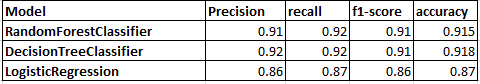

- Based on this, next step I aim to explore the feature importance of all predictors of the RandomForestClassfier model, and plot the fist five preditors

In [624]:
# report the predictor importance
des_importances = des_clf.feature_importances_
des_sorted_indices = np.argsort(des_importances)[::-1]
#importances_list=pd.DataFrame(importances)
des_importances_list=sorted(des_importances,reverse=True)
des_predictor_list= pd.DataFrame(X_train.columns[des_sorted_indices])
des_predictor_list=rand_predictor_list.rename({0:'predictor'},axis=1)
des_predictor_list['rand_importance']=des_importances_list
des_predictor_list

,predictor,rand_importance
0,complete_reward,0.528481
1,offer_reward,0.334609
2,difficulty,0.052491
3,social,0.046610
4,informational,0.012929
5,duration,0.004204
6,discount,0.002050
7,bogo,0.001916
8,mobile,0.001842
9,web,0.001822


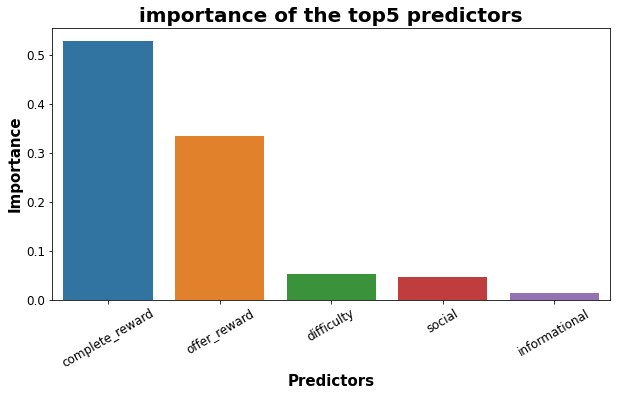

In [625]:
# Ploty the first five predictors
des_predictor_list_top5=des_predictor_list[0:5]
plt.figure(figsize=(10,5))
g=sns.barplot(data=des_predictor_list_top5,x='predictor',y='rand_importance',palette="tab10").set_title('importance of the top5 predictors',fontsize=20,fontweight='bold')
plt.xticks(fontsize = 12,rotation=30)
plt.yticks(fontsize = 12)
plt.xlabel('Predictors',fontsize=15,fontweight='bold')
plt.ylabel('Importance',fontsize=15,fontweight='bold')
figure=g.get_figure()
figure.savefig("Figure 3.jpg")

## STEP 3 Conclusion & Limitation

#### For transactions:
- There is a clear trend that the female has the higher transaction than other two gender group;
- Although there is a little bit difference between gender group, overall, the higher income group has the higher transaction;
- Three models all provide fair to good results, but the DecisionTreeClassifier model generated the best result;

#### For offers:
- According to the above results, we can see that the reward given by completing the offer provides is the most important predictor of the offer complete. 
- Among the three offer type (i.e.informational, discount, bogo), the informational type offer is more likely to be completed.
- The social channel might has the better effect on the offer complete
- The longer duration of the offer might result in more complete.


#### Limitation

- It was kind of arbitrary when separating the income and age group, which might influence the regression analysis results;
- In further analysis, more statistics analysis should be included (e.g. if there is significant difference in transaction between different income groups? if there is interaction effect between income and gender etc.)
- Recommendation analysis can be considered in future.